In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33965")
client

<Client: 'tcp://127.0.0.1:33965' processes=8 threads=40, memory=157.36 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:37045' processes=0 threads=0, memory=0 B>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
import xrft
import xwavelet
from scipy.interpolate import griddata
from scipy.stats import bootstrap
from xgcm.grid import Grid
import MITgcmutils as mitutils
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]
reg = 0

xo = 50e3

nmembs = np.arange(100,148)
xchunk = 200
ychunk = 200

In [7]:
iiter = 1419120
dg = 0
# dsb = xr.open_zarr(op.join(savedir,'Snaps_EnsMean_0001419123.zarr')
#                   ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
#                         YG=slice(ys[reg]-5,ys[reg]+5),
#                         XC=slice(xs[reg]-5,xs[reg]+5),
#                         XG=slice(xs[reg]-5,xs[reg]+5)
#                        )
dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=iiter, 
                     ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                           YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                           XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                           XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                          ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
# dsUmb = xr.open_zarr(op.join(savedir,'SnapsUm_EnsMean_0001419123.zarr')
#                     ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
#                           XG=slice(xs[reg]-5,xs[reg]+5)
#                          )
dsUmb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                        grid_dir=gdir,
                        prefix=['diagUm'], delta_t=2e2,
                        iters=iiter, 
                        ignore_unknown_vars=True
                       ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                             YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                             XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                             XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                            ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
if len(dsb.XG) > len(dsb.XC):
     dsb = dsb.isel(XG=slice(None,-1))
if len(dsUmb.XG) > len(dsb.XC):
     dsUmb = dsUmb.isel(XG=slice(None,-1))
# dsVmb = xr.open_zarr(op.join(savedir,'SnapsVm_EnsMean_0001419123.zarr')
#                     ).sel(YG=slice(ys[reg]-5,ys[reg]+5),
#                           XC=slice(xs[reg]-5,xs[reg]+5)
#                          )
dsVmb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                        grid_dir=gdir,
                        prefix=['diagVm'], delta_t=2e2,
                        iters=iiter, 
                        ignore_unknown_vars=True
                       ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                             YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                             XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                             XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                            ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
dsUmextb = xr.open_zarr(op.join(savedir,'SnapsUm-ext_EnsMean_%010d.zarr' % iiter)
                       ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                             XG=slice(xs[reg]-5,xs[reg]+5)
                            ).isel(XG=slice(None,116))
dsVmextb = xr.open_zarr(op.join(savedir,'SnapsVm-ext_EnsMean_%010d.zarr' % iiter)
                       ).sel(YG=slice(ys[reg]-5,ys[reg]+5),
                             XC=slice(xs[reg]-5,xs[reg]+5)
                            )
dsb

<xarray.Dataset>
Dimensions:  (XC: 116, YC: 120, XG: 116, YG: 120, Z: 46, Zp1: 47, Zu: 46, Zl: 46)
Coordinates: (12/33)
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    time     timedelta64[ns] 3285 days
  * XC       (XC) >f4 290.1 290.1 290.2 290.3 290.4 ... 299.7 299.8 299.9 300.0
  * YC       (YC) >f4 32.0 32.08 32.17 32.25 32.33 ... 41.67 41.75 41.83 41.92
  * XG       (XG) >f4 290.0 290.1 290.2 290.3 290.4 ... 299.7 299.7 299.8 299.9
  * YG       (YG) >f4 32.04 32.13 32.21 32.29 32.38 ... 41.71 41.79 41.88 41.96
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(1, 120, 116), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(1, 120, 116), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(120, 116), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(120, 116), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(120, 116), meta=np.ndarray>
Data variables:
    THETA    (Z, YC, XC) >f4 dask.array<chunksize=(1, 120, 116), meta=np.ndarray>
    SALT     (Z, YC, XC) >f4 dask.array<chunksize=(1, 120, 116), meta=np.ndarray>
    UVEL     (Z, YC, XG) >f4 dask.array<chunksize=(1, 120, 116), meta=np.ndarray>
    VVEL     (Z, YG, XC) >f4 dask.array<chunksize=(1, 120, 116), meta=np.ndarray>
    WVEL     (Zl, YC, XC) >f4 dask.array<chunksize=(1, 120, 116), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [8]:
grid = Grid(dsb, periodic=[], 
            # coords={'Z': {'center': 'Z', 'outer': 'Zp1', 'left':'Zl', 'right':'Zu'},
            #                           'Y': {'center': 'YC', 'left': 'YG'},
            #                           'X': {'center': 'XC', 'left': 'XG'}}
           )
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * outer    Zp1 --> center
  * right    Zu --> center
  * left     Zl --> center
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center

In [9]:
for nmemb in nmembs:
    if nmemb == 100:
        ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['snap_diagOcn'], delta_t=2e2,
                             iters=iiter, 
                             ignore_unknown_vars=True
                            ).isel(time=0).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                               YG=slice(ys[reg]-5,ys[reg]+5),
                                               XC=slice(xs[reg]-5,xs[reg]+5),
                                               XG=slice(xs[reg]-5,xs[reg]+5)
                                              )
    else:
        ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['snap_diagOcn'], delta_t=2e2,
                             iters=iiter, 
                             ignore_unknown_vars=True
                            ).isel(time=0).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                               YG=slice(ys[reg]-5,ys[reg]+5),
                                               XC=slice(xs[reg]-5,xs[reg]+5),
                                               XG=slice(xs[reg]-5,xs[reg]+5)
                                              )
        ds = xr.concat([ds, ds1], dim='nmemb')
        ds1.close()
    print(nmemb)

            # ds = ds.chunk({'nmemb':6})
ds.coords['nmemb'] = ('nmemb',nmembs)
if len(ds.XG) > len(ds.XC):
     ds = ds.isel(XG=slice(None,-1))
ds

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


<xarray.Dataset>
Dimensions:  (XC: 116, YC: 120, XG: 116, YG: 120, Z: 46, Zp1: 47, Zu: 46,
              Zl: 46, nmemb: 48)
Coordinates: (12/34)
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * XC       (XC) >f4 290.1 290.1 290.2 290.3 290.4 ... 299.7 299.8 299.9 300.0
  * YC       (YC) >f4 32.0 32.08 32.17 32.25 32.33 ... 41.67 41.75 41.83 41.92
  * XG       (XG) >f4 290.0 290.1 290.2 290.3 290.4 ... 299.7 299.7 299.8 299.9
  * YG       (YG) >f4 32.04 32.13 32.21 32.29 32.38 ... 41.71 41.79 41.88 41.96
    ...       ...
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 120, 116), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(120, 116), meta=np.ndarray>
    rhoRef   (Z) >f4 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
    maskInW  (YC, XG) bool dask.array<chunksize=(120, 116), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(120, 116), meta=np.ndarray>
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
Data variables:
    THETA    (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
    SALT     (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
    UVEL     (nmemb, Z, YC, XG) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
    VVEL     (nmemb, Z, YG, XC) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
    WVEL     (nmemb, Zl, YC, XC) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [14]:
xT = grid.cumsum(ds.dxC,'X',boundary='extend'
                )
yT = grid.cumsum(ds.dyC,'Y',boundary='extend'
                )
ny, nx = xT.shape
xT = xT - xT.isel(XC=nx//2)
xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
yT = (yT - yT.isel(YC=0)).values.flatten()
dx = ds.dxC.min().values
dy = ds.dyC.min().values
N = ds.THETA.isel(nmemb=0,Z=0).shape

xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]
ntheta = 36
ss = xr.open_zarr('/tank/topog/tuchida/Wavelet-spectrum/isoDiags_KE_region%02d_1967-01-01.zarr' % reg).scale/xo
ss0 = xr.DataArray(np.linspace(2*np.maximum(dx,dy),10*xo,30)/xo, dims=['scale'], 
                  coords={'scale':np.linspace(2*dx,10*xo,30)/xo}
                 )
print(ss,ss0)

<xarray.DataArray 'scale' (scale: 40)>
array([0.39655321, 0.62352005, 0.85048689, 1.07745373, 1.30442056,
       1.5313874 , 1.75835424, 1.98532107, 2.21228791, 2.43925475,
       2.66622158, 2.89318842, 3.12015526, 3.3471221 , 3.57408893,
       3.80105577, 4.02802261, 4.25498944, 4.48195628, 4.70892312,
       4.93588995, 5.16285679, 5.38982363, 5.61679047, 5.8437573 ,
       6.07072414, 6.29769098, 6.52465781, 6.75162465, 6.97859149,
       7.20555832, 7.43252516, 7.659492  , 7.88645884, 8.11342567,
       8.34039251, 8.56735935, 8.79432618, 9.02129302, 9.24825986])
Coordinates:
  * scale    (scale) float64 1.983e+04 3.118e+04 ... 4.511e+05 4.624e+05 <xarray.DataArray (scale: 30)>
array([ 0.3705916 ,  0.70264017,  1.03468873,  1.3667373 ,  1.69878586,
        2.03083443,  2.36288299,  2.69493156,  3.02698013,  3.35902869,
        3.69107726,  4.02312582,  4.35517439,  4.68722295,  5.01927152,
        5.35132008,  5.68336865,  6.01541721,  6.34746578,  6.67951435,
        7.01156291,

In [15]:
for nmemb in nmembs:
    if nmemb == 100:
        dsUm = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (nmemb)), 
                               grid_dir=gdir,
                               prefix=['diagUm'], delta_t=2e2,
                               iters=iiter, 
                               ignore_unknown_vars=True
                              ).reset_coords(drop=True).isel(time=0).drop_dims(['YG','XC','Zl','Zu','Zp1']
                                                                              ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                                                    XG=slice(xs[reg]-5,xs[reg]+5)
                                                                                   )
        
    else:
        ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (nmemb)), 
                              grid_dir=gdir,
                              prefix=['diagUm'], delta_t=2e2,
                              iters=iiter, 
                              ignore_unknown_vars=True
                             ).reset_coords(drop=True).isel(time=0).drop_dims(['YG','XC','Zl','Zu','Zp1']
                                                                             ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                                                   XG=slice(xs[reg]-5,xs[reg]+5)
                                                                                  )
        
        dsUm = xr.concat([dsUm, ds1], dim='nmemb')
        ds1.close()
    print(nmemb)

            # ds = ds.chunk({'nmemb':6})
dsUm.coords['nmemb'] = ('nmemb',nmembs)
if len(dsUm.XG) > len(ds.XC):
     dsUm = dsUm.isel(XG=slice(None,-1))
dsUm

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


,Array,Chunk
Bytes,117.25 MiB,2.44 MiB
Shape,"(48, 46, 120, 116)","(1, 46, 120, 116)"
Count,1559 Tasks,48 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,117.25 MiB,2.44 MiB
Shape,"(48, 46, 120, 116)","(1, 46, 120, 116)"
Count,1559 Tasks,48 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [16]:
for nmemb in nmembs:
    if nmemb == 100:
        dsVm = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (nmemb)), 
                               grid_dir=gdir,
                               prefix=['diagVm'], delta_t=2e2,
                               iters=iiter, 
                               ignore_unknown_vars=True
                              ).reset_coords(drop=True).isel(time=0).drop_dims(['YC','XG','Zl','Zu','Zp1']
                                                                              ).sel(YG=slice(ys[reg]-5,ys[reg]+5),
                                                                                    XC=slice(xs[reg]-5,xs[reg]+5)
                                                                                   )
        
    else:
        ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (nmemb)), 
                              grid_dir=gdir,
                              prefix=['diagVm'], delta_t=2e2,
                              iters=iiter, 
                              ignore_unknown_vars=True
                             ).reset_coords(drop=True).isel(time=0).drop_dims(['YC','XG','Zl','Zu','Zp1']
                                                                             ).sel(YG=slice(ys[reg]-5,ys[reg]+5),
                                                                                   XC=slice(xs[reg]-5,xs[reg]+5)
                                                                                  )
        
        dsVm = xr.concat([dsVm, ds1], dim='nmemb')
        ds1.close()
    print(nmemb)

            # ds = ds.chunk({'nmemb':6})
dsVm.coords['nmemb'] = ('nmemb',nmembs)
dsVm

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


,Array,Chunk
Bytes,117.25 MiB,2.44 MiB
Shape,"(48, 46, 120, 116)","(1, 46, 120, 116)"
Count,1511 Tasks,48 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,117.25 MiB,2.44 MiB
Shape,"(48, 46, 120, 116)","(1, 46, 120, 116)"
Count,1511 Tasks,48 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [17]:
up = (ds.UVEL - dsb.UVEL).where(ds.maskW!=0.)
upC = grid.interp(up,'X',boundary='extend').isel(Z=[14,18,24]).load()
vp = (ds.VVEL - dsb.VVEL).where(ds.maskS!=0.)
vpC = grid.interp(vp,'Y',boundary='extend').isel(Z=[14,18,24]).load()
wp = (ds.WVEL - dsb.WVEL)

ub = dsb.UVEL.where(ds.maskW!=0.)
ubC = grid.interp(ub,'X',boundary='extend').isel(Z=[14,18,24]).load()
vb = dsb.VVEL.where(ds.maskS!=0.)
vbC = grid.interp(vb,'Y',boundary='extend').isel(Z=[14,18,24]).load()

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(


In [18]:
rAterp = griddata((xT, yT), ds.rA.values.flatten(),
                  (xxx, yyy) 
                 ).T

In [19]:
uterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                     coords={'nmemb':nmembs,'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                     coords={'nmemb':nmembs,'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )

for iz in range(len(upC.Z)):
    for nn in range(len(nmembs)):
        uterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT),
                                                (upC*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 
        vterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                (vpC*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 
        
uterp = uterp / rAterp
vterp = vterp / rAterp

In [20]:
uinterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                     coords={'nmemb':nmembs,'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                     coords={'nmemb':nmembs,'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )

for iz in range(len(upC.Z)):
    for nn in range(len(nmembs)):
        uinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), (upC.interpolate_na(dim='XC'
                                                                            ).interpolate_na(dim='YC'
                                                                                            ).fillna(0.) 
                                                             * ds.rA
                                                            ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T 
        vinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), (vpC.interpolate_na(dim='YC'
                                                                            ).interpolate_na(dim='XC'
                                                                                            ).fillna(0.) 
                                                             * ds.rA
                                                            ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T 
        
uinterp = uinterp / rAterp
vinterp = vinterp / rAterp

In [21]:
Tp = grid.interp((dsUm.TOTUTEND - dsUmb.TOTUTEND).where(ds.maskW!=0.),
                 'X',boundary='extend').isel(Z=[14,18,24]).load()
Ap = grid.interp((
                  dsUm.Um_Advec 
                  # - dsUm.Um_Cori
                 # ).where(ds.maskW!=0.)
                 - 
                   # (
                    dsUmb.Um_Advec 
                    # - dsUmb.Um_Cori
                   ).where(ds.maskW!=0.),
                 'X',boundary='extend').isel(Z=[14,18,24]).load()
Pp = grid.interp((dsUm.Um_dPHdx - dsUmb.Um_dPHdx).where(ds.maskW!=0.),
                 'X',boundary='extend').isel(Z=[14,18,24]).load()
# Dp = dsUm.Um_Diss - dsUmb.Um_Diss
ABp = grid.interp((dsUm.AB_gU - dsUmb.AB_gU).where(ds.maskW!=0.),
                  'X',boundary='extend').isel(Z=[14,18,24]).load()

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(


In [22]:
Pterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                     coords={'nmemb':nmembs,'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
Tterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                     coords={'nmemb':nmembs,'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
Aterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                     coords={'nmemb':nmembs,'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
ABterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                      coords={'nmemb':nmembs,'Z':upC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
                
        
for iz in range(len(upC.Z)):
    for nn in range(len(nmembs)):
        Tterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                (Tp*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 
        Pterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                (Pp*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T
        Aterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                (Ap*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 
        ABterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (ABp*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 

Tterp = Tterp / rAterp
Aterp = Aterp / rAterp
Pterp = Pterp / rAterp
ABterp = ABterp / rAterp
            

iso_uAB = xwavelet.wvlt_cross_spectrum(
                    uterp, ABterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_uP = xwavelet.wvlt_cross_spectrum(
                    uterp, Pterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_uT = xwavelet.wvlt_cross_spectrum(
                    uterp, Tterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_uA = xwavelet.wvlt_cross_spectrum(
                    uterp, Aterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
        
dsave = iso_uAB.to_dataset(name='iso_uAB')
dsave['iso_uP'] = iso_uP
dsave['iso_uT'] = iso_uT
dsave['iso_uA'] = iso_uA
dsave.encoding = {}
dsave.to_zarr(op.join(savedir,'isoDiags_u_region%02d_1967-01-01.zarr' % reg),
              mode='w')
dsave.close()

In [23]:
Pinterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                     coords={'nmemb':nmembs,'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
Tinterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                     coords={'nmemb':nmembs,'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
Ainterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                     coords={'nmemb':nmembs,'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
ABinterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                      coords={'nmemb':nmembs,'Z':upC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
                
        
for iz in range(len(upC.Z)):
    for nn in range(len(nmembs)):
        Tinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                  (Tp.interpolate_na(dim='XC').interpolate_na(dim='YC'
                                                                                            ).fillna(0.) 
                                                   * ds.rA
                                                  ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T 
        Pinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                  (Pp.interpolate_na(dim='XC').interpolate_na(dim='YC'
                                                                                            ).fillna(0.) 
                                                   * ds.rA
                                                  ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T
        Ainterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                  (Ap.interpolate_na(dim='XC').interpolate_na(dim='YC'
                                                                                            ).fillna(0.) 
                                                   * ds.rA
                                                  ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T 
        ABinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                   (ABp.interpolate_na(dim='XC').interpolate_na(dim='YC'
                                                                                            ).fillna(0.) 
                                                    * ds.rA
                                                   ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                   (xxx, yyy) 
                                                  ).T 

Tinterp = Tinterp / rAterp
Ainterp = Ainterp / rAterp
Pinterp = Pinterp / rAterp
ABinterp = ABinterp / rAterp
            

cs_uAB = xrft.cross_spectrum(
                    uinterp.chunk({'YC':-1,'XC':-1}), ABinterp.chunk({'YC':-1,'XC':-1}), 
                    dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
        )
cs_uP = xrft.cross_spectrum(
                    uinterp.chunk({'YC':-1,'XC':-1}), Pinterp.chunk({'YC':-1,'XC':-1}), 
                    dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
        )
cs_uT = xrft.cross_spectrum(
                    uinterp.chunk({'YC':-1,'XC':-1}), Tinterp.chunk({'YC':-1,'XC':-1}), 
                    dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
        )
cs_uA = xrft.cross_spectrum(
                    uinterp.chunk({'YC':-1,'XC':-1}), Ainterp.chunk({'YC':-1,'XC':-1}), 
                    dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
        )
        
dsave = cs_uAB.to_dataset(name='cs_uAB')
dsave['cs_uP'] = cs_uP
dsave['cs_uT'] = cs_uT
dsave['cs_uA'] = cs_uA
dsave.encoding = {}
dsave.to_zarr(op.join(savedir,'crossFourierDiags_u_region%02d_1967-01-01.zarr' % reg),
                      mode='w')
dsave.close()

In [24]:
Tp = grid.interp((dsVm.TOTVTEND - dsVmb.TOTVTEND).where(ds.maskS!=0.),
                 'Y',boundary='extend').isel(Z=[14,18,24]).load()
Ap = grid.interp((
                  dsVm.Vm_Advec 
                  # - dsVm.Vm_Cori
                 # ).where(ds.maskS!=0.)
                 - 
                   # (
                    dsVmb.Vm_Advec 
                    # - dsVmb.Vm_Cori
                   ).where(ds.maskS!=0.),
                 'Y',boundary='extend').isel(Z=[14,18,24]).load()
Pp = grid.interp((dsVm.Vm_dPHdy - dsVmb.Vm_dPHdy).where(ds.maskS!=0.),
                 'Y',boundary='extend').isel(Z=[14,18,24]).load()
# Dp = dsUm.Um_Diss - dsUmb.Um_Diss
ABp = grid.interp((dsVm.AB_gV - dsVmb.AB_gV).where(ds.maskS!=0.),
                  'Y',boundary='extend').isel(Z=[14,18,24]).load()

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(


In [25]:
Pterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                     coords={'nmemb':nmembs,'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
Tterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                     coords={'nmemb':nmembs,'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
Aterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                     coords={'nmemb':nmembs,'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
ABterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
        
        
for iz in range(len(vpC.Z)):
    for nn in range(len(nmembs)):
        Tterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                (Tp*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 
        Pterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                (Pp*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 
        Aterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                (Ap*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 
        ABterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (ABp*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 

Tterp = Tterp / rAterp
Aterp = Aterp / rAterp
Pterp = Pterp / rAterp
ABterp = ABterp / rAterp
            

iso_vAB = xwavelet.wvlt_cross_spectrum(
                    vterp, ABterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_vP = xwavelet.wvlt_cross_spectrum(
                    vterp, Pterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_vT = xwavelet.wvlt_cross_spectrum(
                    vterp, Tterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_vA = xwavelet.wvlt_cross_spectrum(
                    vterp, Aterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
        
dsave = iso_vAB.to_dataset(name='iso_vAB')
dsave['iso_vP'] = iso_vP
dsave['iso_vT'] = iso_vT
dsave['iso_vA'] = iso_vA
dsave.encoding = {}
dsave.to_zarr(op.join(savedir,'isoDiags_v_region%02d_1967-01-01.zarr' % reg),
              mode='w')
dsave.close()

In [26]:
Pinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                     coords={'nmemb':nmembs,'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
Tinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                     coords={'nmemb':nmembs,'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
Ainterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                     coords={'nmemb':nmembs,'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
ABinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
        
        
for iz in range(len(vpC.Z)):
    for nn in range(len(nmembs)):
        Tinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), (Tp.interpolate_na(dim='YC'
                                                                            ).interpolate_na(dim='XC'
                                                                                            ).fillna(0.) 
                                                             * ds.rA
                                                          ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 
        Pinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), (Pp.interpolate_na(dim='YC'
                                                                            ).interpolate_na(dim='XC'
                                                                                            ).fillna(0.) 
                                                             * ds.rA
                                                          ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 
        Ainterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), (Ap.interpolate_na(dim='YC'
                                                                            ).interpolate_na(dim='XC'
                                                                                            ).fillna(0.) 
                                                             * ds.rA
                                                          ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 
        ABinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), (ABp.interpolate_na(dim='YC'
                                                                            ).interpolate_na(dim='XC'
                                                                                            ).fillna(0.) 
                                                              * ds.rA
                                                           ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 

Tinterp = Tinterp / rAterp
Ainterp = Ainterp / rAterp
Pinterp = Pinterp / rAterp
ABinterp = ABinterp / rAterp
            
ntheta = 36

cs_vAB = xrft.cross_spectrum(
                    vinterp.chunk({'YC':-1,'XC':-1}), ABinterp.chunk({'YC':-1,'XC':-1}), 
                    dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
        )
cs_vP = xrft.cross_spectrum(
                    vinterp.chunk({'YC':-1,'XC':-1}), Pinterp.chunk({'YC':-1,'XC':-1}), 
                    dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
        )
cs_vT = xrft.cross_spectrum(
                    vinterp.chunk({'YC':-1,'XC':-1}), Tinterp.chunk({'YC':-1,'XC':-1}), 
                    dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
        )
cs_vA = xrft.cross_spectrum(
                    vinterp.chunk({'YC':-1,'XC':-1}), Ainterp.chunk({'YC':-1,'XC':-1}), 
                    dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
        )
        
dsave = cs_vAB.to_dataset(name='cs_vAB')
dsave['cs_vP'] = cs_vP
dsave['cs_vT'] = cs_vT
dsave['cs_vA'] = cs_vA
dsave.encoding = {}
dsave.to_zarr(op.join(savedir,'crossFourierDiags_v_region%02d_1967-01-01.zarr' % reg),
                      mode='w')
dsave.close()

In [27]:
for nmemb in nmembs:
    if nmemb == 100:
        ds_raw = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['diagUm'], delta_t=2e2,
                                 iters=iiter, 
                                 ignore_unknown_vars=True
                                ).reset_coords(drop=True).isel(time=0).drop_dims(['YG','XC','Zl','Zu','Zp1']).chunk({'YC':ychunk,'XG':xchunk,
                                                                                                                     'Z':10})
        Um_dEdx = xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%03d/run1967/ocn/diagUm' 
                                              % (nmemb)), itrs=iiter, rec=3,    # U from surface pressure
                             # usememmap=True
                                             ),
                               dims=ds_raw.TOTUTEND.dims, coords=ds_raw.TOTUTEND.coords
                              ).sel(YC=slice(ys[reg]-5,ys[reg]+5),XG=slice(xs[reg]-5,xs[reg]+5)
                                   )
        
        Um_Disv = xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%03d/run1967/ocn/diagUm' 
                                                      % (nmemb)), itrs=iiter, rec=5,    # Vertical dissipation
                             # usememmap=True
                                             ),
                               dims=ds_raw.TOTUTEND.dims, coords=ds_raw.TOTUTEND.coords
                              ).sel(YC=slice(ys[reg]-5,ys[reg]+5),XG=slice(xs[reg]-5,xs[reg]+5)
                                   )
    else:
        Um_dEdx = xr.concat([Um_dEdx, xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%03d/run1967/ocn/diagUm' 
                                                                  % (nmemb)), itrs=iiter, rec=3,    # U from surface pressure
                                              # usememmap=True
                                                                 ),
                                                   dims=ds_raw.TOTUTEND.dims, coords=ds_raw.TOTUTEND.coords
                                                  ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                        XG=slice(xs[reg]-5,xs[reg]+5)
                                                       )], dim='nmemb')
        Um_Disv = xr.concat([Um_Disv, xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%03d/run1967/ocn/diagUm' 
                                                                  % (nmemb)), itrs=iiter, rec=5,    # Vertical dissipation
                                              # usememmap=True
                                                                 ),
                                                   dims=ds_raw.TOTUTEND.dims, coords=ds_raw.TOTUTEND.coords
                                                  ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                        XG=slice(xs[reg]-5,xs[reg]+5)
                                                       )], dim='nmemb')
        
    print(nmemb)

            # ds = ds.chunk({'nmemb':6})
Um_dEdx.coords['nmemb'] = ('nmemb',nmembs)
Um_Disv.coords['nmemb'] = ('nmemb',nmembs)
if len(Um_dEdx.XG) > len(dsb.XC):
     Um_dEdx = Um_dEdx.isel(XG=slice(None,-1))
if len(Um_Disv.XG) > len(dsb.XC):
     Um_Disv = Um_Disv.isel(XG=slice(None,-1))
Um_dEdx

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


<xarray.DataArray (nmemb: 48, Z: 46, YC: 120, XG: 116)>
array([[[[-3.29633622e-06, -2.74547506e-06, -2.02493902e-06, ...,
           7.52345750e-06,  7.53443783e-06,  7.33522984e-06],
         [-5.30492207e-06, -4.59518378e-06, -3.65928918e-06, ...,
           5.64258789e-06,  5.75509875e-06,  5.73406123e-06],
         [-7.11452503e-06, -6.21606205e-06, -5.04369655e-06, ...,
           4.12412146e-06,  4.22880339e-06,  4.23595839e-06],
         ...,
         [ 0.00000000e+00,  2.67392752e-05,  2.38171342e-05, ...,
          -1.08312934e-05, -1.35518212e-05, -1.63850564e-05],
         [ 0.00000000e+00,  2.66002353e-05,  2.30312198e-05, ...,
          -9.67606320e-06, -1.16320625e-05, -1.36722747e-05],
         [ 0.00000000e+00,  2.09478894e-05,  1.96215988e-05, ...,
          -8.72840246e-06, -9.93079811e-06, -1.10114652e-05]],

        [[-3.29633622e-06, -2.74547506e-06, -2.02493902e-06, ...,
           7.52345750e-06,  7.53443783e-06,  7.33522984e-06],
         [-5.30492207e-06, -4.59518378e-06, -3.65928918e-06, ...,
           5.64258789e-06,  5.75509875e-06,  5.73406123e-06],
         [-7.11452503e-06, -6.21606205e-06, -5.04369655e-06, ...,
           4.12412146e-06,  4.22880339e-06,  4.23595839e-06],
...
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]])
Coordinates:
    time     timedelta64[ns] 3285 days
  * YC       (YC) >f4 32.0 32.08 32.17 32.25 32.33 ... 41.67 41.75 41.83 41.92
  * XG       (XG) >f4 290.0 290.1 290.2 290.3 290.4 ... 299.7 299.7 299.8 299.9
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147

In [94]:
upDv = (up*(Um_Disv - Um_Disv.mean('nmemb'))).mean('nmemb',skipna=True)
upDv

<xarray.DataArray (Z: 46, YC: 120, XG: 116)>
dask.array<mean_agg-aggregate, shape=(46, 120, 116), dtype=float64, chunksize=(46, 63, 75), chunktype=numpy.ndarray>
Coordinates: (12/14)
    iter     int64 1419123
    time     timedelta64[ns] 3285 days 00:10:00
  * YC       (YC) >f4 17.0 17.08 17.17 17.25 17.33 ... 26.67 26.75 26.83 26.92
  * XG       (XG) >f4 310.1 310.1 310.2 310.3 310.4 ... 319.7 319.8 319.9 320.0
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
    dyG      (YC, XG) >f4 9.265e+03 9.265e+03 9.265e+03 ... 9.265e+03 9.265e+03
    ...       ...
    drF      (Z) >f4 6.094 6.721 7.099 7.971 8.65 ... 248.9 249.6 249.9 250.5
    PHrefC   (Z) >f4 29.89 92.74 160.5 234.4 ... 5.273e+04 5.518e+04 5.764e+04
    hFacW    (Z, YC, XG) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskW    (Z, YC, XG) bool True True True True ... False False False False
    rhoRef   (Z) >f4 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
    maskInW  (YC, XG) bool True True True True True ... True True True True True

In [28]:
Dp = grid.interp((dsUm.Um_Diss - dsUmb.Um_Diss).where(ds.maskW!=0.)
                 + (Um_Disv - dsUmextb.Um_Disv).where(ds.maskW!=0.),
                 'X',boundary='extend').isel(Z=[14,18,24]).load()
Ep = grid.interp((Um_dEdx - dsUmextb.Um_dEdx).where(ds.maskW!=0.),
                 'X',boundary='extend').isel(Z=[14,18,24]).load()

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(


In [29]:
Dterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                     coords={'nmemb':nmembs,'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
Eterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                     coords={'nmemb':nmembs,'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
        
    
for iz in range(len(upC.Z)):
    for nn in range(len(nmembs)):
        Dterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                (Dp*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 
        Eterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT),
                                                (Ep*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 

Dterp = Dterp / rAterp
Eterp = Eterp / rAterp


iso_uD = xwavelet.wvlt_cross_spectrum(
                    uterp, Dterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
         )
iso_uE = xwavelet.wvlt_cross_spectrum(
                    uterp, Eterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
         )

        
dsave = iso_uD.to_dataset(name='iso_uD')
dsave['iso_uE'] = iso_uE
dsave.encoding = {}
dsave.to_zarr(op.join(savedir,'isoDiags-ext_u_region%02d_1967-01-01.zarr' % reg),
                      mode='w')
dsave.close()

In [30]:
Dinterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                     coords={'nmemb':nmembs,'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
Einterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                     coords={'nmemb':nmembs,'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
        
    
for iz in range(len(upC.Z)):
    for nn in range(len(nmembs)):
        Dinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                (Dp.interpolate_na(dim='XC'
                                                                  ).interpolate_na(dim='YC'
                                                                                  ).fillna(0.) 
                                                 * ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 
        Einterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT),
                                                (Ep.interpolate_na(dim='XC'
                                                                  ).interpolate_na(dim='YC'
                                                                                  ).fillna(0.) 
                                                 * ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 

Dinterp = Dinterp / rAterp
Einterp = Einterp / rAterp
            
cs_uD = xrft.cross_spectrum(
                    uinterp.chunk({'YC':-1,'XC':-1}), Dinterp.chunk({'YC':-1,'XC':-1}), 
                    dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
        )
cs_uE = xrft.cross_spectrum(
                    uinterp.chunk({'YC':-1,'XC':-1}), Einterp.chunk({'YC':-1,'XC':-1}), 
                    dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
        )

        
dsave = cs_uD.to_dataset(name='cs_uD')
dsave['cs_uE'] = cs_uE
dsave.encoding = {}
dsave.to_zarr(op.join(savedir,'crossFourierDiags-ext_u_region%02d_1967-01-01.zarr' % reg),
                      mode='w')
dsave.close()

In [31]:
for nmemb in nmembs:
    if nmemb == 100:
        ds_raw = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['diagVm'], delta_t=2e2,
                                 iters=iiter, 
                                 ignore_unknown_vars=True
                                ).reset_coords(drop=True).isel(time=0).drop_dims(['YC','XG','Zl','Zu','Zp1']).chunk({'YG':ychunk,'XC':xchunk,
                                                                                                                     'Z':10})
        Vm_dEdy = xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%03d/run1967/ocn/diagVm' 
                                              % (nmemb)), itrs=iiter, rec=3,    # U from surface pressure
                             # usememmap=True
                                             ),
                               dims=ds_raw.TOTVTEND.dims, coords=ds_raw.TOTVTEND.coords
                              ).sel(YG=slice(ys[reg]-5,ys[reg]+5),XC=slice(xs[reg]-5,xs[reg]+5)
                                   )
        
        Vm_Disv = xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%03d/run1967/ocn/diagVm' 
                                              % (nmemb)), itrs=iiter, rec=5,    # Vertical dissipation
                             # usememmap=True
                                             ),
                               dims=ds_raw.TOTVTEND.dims, coords=ds_raw.TOTVTEND.coords
                              ).sel(YG=slice(ys[reg]-5,ys[reg]+5),XC=slice(xs[reg]-5,xs[reg]+5)
                                   )
    else:
        Vm_dEdy = xr.concat([Vm_dEdy, xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%03d/run1967/ocn/diagVm' 
                                                                  % (nmemb)), itrs=iiter, rec=3,    # U from surface pressure
                                              # usememmap=True
                                                                 ),
                                                   dims=ds_raw.TOTVTEND.dims, coords=ds_raw.TOTVTEND.coords
                                                  ).sel(YG=slice(ys[reg]-5,ys[reg]+5),
                                                        XC=slice(xs[reg]-5,xs[reg]+5))], dim='nmemb')
        Vm_Disv = xr.concat([Vm_Disv, xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%03d/run1967/ocn/diagVm' 
                                                                  % (nmemb)), itrs=iiter, rec=5,    # Vertical dissipation
                                              # usememmap=True
                                                                 ),
                                                   dims=ds_raw.TOTVTEND.dims, coords=ds_raw.TOTVTEND.coords
                                                  ).sel(YG=slice(ys[reg]-5,ys[reg]+5),
                                                        XC=slice(xs[reg]-5,xs[reg]+5))], dim='nmemb')
        
    print(nmemb)

            # ds = ds.chunk({'nmemb':6})
Vm_dEdy.coords['nmemb'] = ('nmemb',nmembs)
Vm_Disv.coords['nmemb'] = ('nmemb',nmembs)
Vm_dEdy

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


<xarray.DataArray (nmemb: 48, Z: 46, YG: 120, XC: 116)>
array([[[[ 2.39877063e-05,  2.23714287e-05,  2.09430127e-05, ...,
          -2.07740632e-05, -2.23369607e-05, -2.37438035e-05],
         [ 2.34294439e-05,  2.20161655e-05,  2.08088604e-05, ...,
          -1.69767554e-05, -1.83156171e-05, -1.96298151e-05],
         [ 2.14052361e-05,  2.03855161e-05,  1.95801240e-05, ...,
          -1.37024208e-05, -1.46976436e-05, -1.56762580e-05],
         ...,
         [ 1.01953383e-05,  1.00615871e-05,  9.43302257e-06, ...,
           3.44625755e-06,  4.93698781e-06,  7.04074910e-06],
         [ 1.10806695e-05,  6.71044882e-06,  4.06723075e-06, ...,
           6.67085078e-06,  7.98985184e-06,  1.00482612e-05],
         [ 1.38914265e-05,  1.06825846e-05,  6.40231747e-06, ...,
           5.40449446e-06,  7.85219709e-06,  1.04707415e-05]],

        [[ 2.39877063e-05,  2.23714287e-05,  2.09430127e-05, ...,
          -2.07740632e-05, -2.23369607e-05, -2.37438035e-05],
         [ 2.34294439e-05,  2.20161655e-05,  2.08088604e-05, ...,
          -1.69767554e-05, -1.83156171e-05, -1.96298151e-05],
         [ 2.14052361e-05,  2.03855161e-05,  1.95801240e-05, ...,
          -1.37024208e-05, -1.46976436e-05, -1.56762580e-05],
...
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]])
Coordinates:
    time     timedelta64[ns] 3285 days
  * XC       (XC) >f4 290.1 290.1 290.2 290.3 290.4 ... 299.7 299.8 299.9 300.0
  * YG       (YG) >f4 32.04 32.13 32.21 32.29 32.38 ... 41.71 41.79 41.88 41.96
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147

In [98]:
vpDv = (vp*(Vm_Disv - Vm_Disv.mean('nmemb',skipna=True))).mean('nmemb',skipna=True)
vpDv

<xarray.DataArray (Z: 46, YG: 120, XC: 116)>
dask.array<mean_agg-aggregate, shape=(46, 120, 116), dtype=float64, chunksize=(46, 64, 74), chunktype=numpy.ndarray>
Coordinates: (12/14)
    iter     int64 1419123
    time     timedelta64[ns] 3285 days 00:10:00
  * XC       (XC) >f4 310.0 310.1 310.2 310.3 310.4 ... 319.7 319.7 319.8 319.9
  * YG       (YG) >f4 17.04 17.13 17.21 17.29 17.38 ... 26.71 26.79 26.88 26.96
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
    dxG      (YG, XC) >f4 9.148e+03 9.148e+03 9.148e+03 ... 8.528e+03 8.528e+03
    ...       ...
    drF      (Z) >f4 6.094 6.721 7.099 7.971 8.65 ... 248.9 249.6 249.9 250.5
    PHrefC   (Z) >f4 29.89 92.74 160.5 234.4 ... 5.273e+04 5.518e+04 5.764e+04
    hFacS    (Z, YG, XC) >f4 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    maskS    (Z, YG, XC) bool True True True True ... False False False False
    rhoRef   (Z) >f4 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
    maskInS  (YG, XC) bool True True True True True ... True True True True True

In [32]:
Dp = grid.interp((dsVm.Vm_Diss - dsVmb.Vm_Diss).where(ds.maskS!=0.)
                 + (Vm_Disv - dsVmextb.Vm_Disv).where(ds.maskS!=0.),
                 'Y',boundary='extend').isel(Z=[14,18,24]).load()
Ep = grid.interp((Vm_dEdy - dsVmextb.Vm_dEdy).where(ds.maskS!=0.),
                 'Y',boundary='extend').isel(Z=[14,18,24]).load()

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/dask/array/core.py:4618: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(


In [33]:
Dterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                     coords={'nmemb':nmembs,'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
Eterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                     coords={'nmemb':nmembs,'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
        

for iz in range(len(upC.Z)):
    for nn in range(len(nmembs)):
        Dterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT),
                                                (Dp*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 
        Eterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                (Ep*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 

        
Dterp = Dterp / rAterp
Eterp = Eterp / rAterp
            

iso_vD = xwavelet.wvlt_cross_spectrum(
                    vterp, Dterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
         )
iso_vE = xwavelet.wvlt_cross_spectrum(
                    vterp, Eterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
         )

        
dsave = iso_vD.to_dataset(name='iso_vD')
dsave['iso_vE'] = iso_vE
dsave.encoding = {}
dsave.to_zarr(op.join(savedir,'isoDiags-ext_v_region%02d_1967-01-01.zarr' % reg),
                      mode='w')
dsave.close()

In [26]:
Dinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                     coords={'nmemb':nmembs,'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
Einterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                     coords={'nmemb':nmembs,'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
        

for iz in range(len(vpC.Z)):
    for nn in range(len(nmembs)):
        Dinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), (Dp.interpolate_na(dim='YC'
                                                                            ).interpolate_na(dim='XC'
                                                                                            ).fillna(0.) 
                                                             * ds.rA
                                                            ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T 
        Einterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), (Ep.interpolate_na(dim='YC'
                                                                            ).interpolate_na(dim='XC'
                                                                                            ).fillna(0.) 
                                                             * ds.rA
                                                            ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                  (xxx, yyy) 
                                                 ).T 

        
Dinterp = Dinterp / rAterp
Einterp = Einterp / rAterp

cs_vD = xrft.cross_spectrum(
                    vinterp.chunk({'YC':-1,'XC':-1}), Dinterp.chunk({'YC':-1,'XC':-1}), 
                    dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
        )
cs_vE = xrft.cross_spectrum(
                    vinterp.chunk({'YC':-1,'XC':-1}), Einterp.chunk({'YC':-1,'XC':-1}), 
                    dim=["YC", "XC"], window='hann', true_phase=True, 
                    window_correction=True
        )

        
dsave = cs_vD.to_dataset(name='cs_vD')
dsave['cs_vE'] = cs_vE
dsave.encoding = {}
dsave.to_zarr(op.join(savedir,'crossFourierDiags-ext_v_region%02d_1967-01-01.zarr' % reg),
                      mode='w')
dsave.close()

In [34]:
xA = (ds.dyG * ds.drF).reset_coords(drop=True)
yA = (ds.dxG * ds.drF).reset_coords(drop=True)

upTrans = up * xA
vpTrans = vp * yA
rpTrans = grid.interp(wp,'X',boundary='extend') * ds.rAw
Auup = (grid.interp(upTrans,'X',boundary='extend')
        * grid.interp(up,'X',boundary='extend')
       )
Avup = (grid.interp(vpTrans,'X',boundary='extend')
        * grid.interp(up,'Y',boundary='extend')
       )
Awup = (rpTrans
        * grid.interp(up,'Z',boundary='extend')
       )
rpTrans = grid.interp(wp,'Y',boundary='extend') * ds.rAs
Auvp = (grid.interp(upTrans,'Y',boundary='extend')
        * grid.interp(vp,'X',boundary='extend')
       )
Avvp = (grid.interp(vpTrans,'Y',boundary='extend')
        * grid.interp(vp,'Y',boundary='extend')
       )
Awvp = (rpTrans
        * grid.interp(vp,'Z',boundary='extend')
       )
Aut = grid.interp(((grid.diff(Auup,'X',boundary='extend')
                    + grid.diff(Avup,'Y',boundary='extend')
                    - grid.diff(Awup,'Z',boundary='extend')
                   ) / ds.drF/ds.rAw
                  ).where(ds.maskW!=0.).reset_coords(drop=True),
                  'X',boundary='extend').isel(Z=[14,18,24]).compute()
Avt = grid.interp(((grid.diff(Auvp,'X',boundary='extend')
                    + grid.diff(Avvp,'Y',boundary='extend')
                    - grid.diff(Awvp,'Z',boundary='extend')
                   ) / ds.drF/ds.rAs
                  ).where(ds.maskS!=0.).reset_coords(drop=True),
                  'Y',boundary='extend').isel(Z=[14,18,24]).compute()

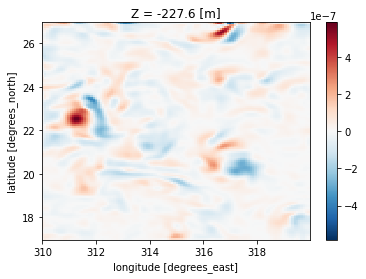

In [25]:
fig, ax = plt.subplots()
Aut.isel(nmemb=0,Z=0).plot(ax=ax)
# ax.set_title(r"MtE")
plt.show()

In [35]:
Auterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                      coords={'nmemb':nmembs,'Z':upC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
Avterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
uterb = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vterb = xr.DataArray(np.ones_like(vbC), dims=vbC.dims,
                     coords={'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
        

for iz in range(len(upC.Z)):
    uterb.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (ubC*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vterb.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vbC*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T
    for nn in range(len(nmembs)):
        Auterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (Aut*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        Avterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (Avt*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 


uterb = uterb / rAterp
vterb = vterb / rAterp        
Auterp = Auterp / rAterp
Avterp = Avterp / rAterp
            
ntheta = 36

iso_UA = xwavelet.wvlt_cross_spectrum(
                    uterb, Auterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_UA = xwavelet.wvlt_cross_spectrum(
                    vterb, Avterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )

        
dsave = iso_UA.to_dataset(name='iso_uA')
dsave['iso_vA'] = iso_UA
dsave.encoding = {}
dsave.to_zarr(op.join(savedir,'isoDiags-MtE_region%02d_1967-01-01.zarr' % reg),
                      mode='w')
dsave.close()

In [36]:
Auinterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                      coords={'nmemb':nmembs,'Z':upC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
Avinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
uinterb = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vinterb = xr.DataArray(np.ones_like(vbC), dims=vbC.dims,
                     coords={'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
        

for iz in range(len(upC.Z)):
    uinterb.isel(Z=iz)[:] = griddata((xT, yT), 
                                     (ubC.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                      * ds.rA
                                     ).isel(Z=iz).values.flatten(),
                                     (xxx, yyy) 
                                    ).T 
    vinterb.isel(Z=iz)[:] = griddata((xT, yT), 
                                     (vbC.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                      * ds.rA
                                     ).isel(Z=iz).values.flatten(),
                                     (xxx, yyy) 
                                    ).T
    for nn in range(len(nmembs)):
        Auinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (Aut.interpolate_na(dim='YC'
                                                                    ).interpolate_na(dim='XC'
                                                                                    ).fillna(0.) 
                                                  * ds.rA
                                                 ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 
        Avinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (Avt.interpolate_na(dim='YC'
                                                                    ).interpolate_na(dim='XC'
                                                                                    ).fillna(0.) 
                                                  * ds.rA
                                                 ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 

uinterb = uinterb / rAterp
vinterb = vinterb / rAterp        
Auinterp = Auinterp / rAterp
Avinterp = Avinterp / rAterp

cs_uA = xr.ones_like(cs_uT)
cs_vA = xr.ones_like(cs_uT)
for i in range(len(nmembs)):
    cs_uA[i] = xrft.cross_spectrum(
                        uinterb.chunk({'YC':-1,'XC':-1}), Auinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                        dim=["YC", "XC"], window='hann', true_phase=True, 
                        window_correction=True
            )
    cs_vA[i] = xrft.cross_spectrum(
                        vinterb.chunk({'YC':-1,'XC':-1}), Avinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                        dim=["YC", "XC"], window='hann', true_phase=True, 
                        window_correction=True
            )

dsave = cs_uA.to_dataset(name='MtEu')
dsave['MtEv'] = cs_vA
dsave.encoding = {}
fname = op.join(savedir,'crossFourierDiags-MtE_region%02d_1967-01-01.zarr' % reg)
print(fname)
dsave.to_zarr(fname, mode='w')
dsave.close()

/tank/topog/tuchida/Wavelet-spectrum/crossFourierDiags-MtE_region00_1967-01-01.zarr


In [37]:
ubx = (grid.diff(ub*ds.dyG*ds.drF,'X',boundary='extend') / ds.rA/ds.drF).isel(Z=[14,18,24]).load()
uby = (grid.interp(grid.interp(grid.diff(ub*ds.dxC*ds.drF,'Y',boundary='extend') / ds.rAz/ds.drF,
                               'X',boundary='extend'),
                   'Y',boundary='extend')).isel(Z=[14,18,24]).load()
ubz = (-grid.interp(grid.interp(grid.diff(ub,'Z',boundary='extend') / ds.drC.data[:-1,np.newaxis,np.newaxis],
                                'Z',boundary='extend'),
                    'X',boundary='extend')).isel(Z=[14,18,24]).load()
vby = (grid.diff(vb*ds.dyC*ds.drF,'Y',boundary='extend') / ds.rA/ds.drF).isel(Z=[14,18,24]).load()
vbx = (grid.interp(grid.interp(grid.diff(vb*ds.dxG*ds.drF,'X',boundary='extend') / ds.rAz/ds.drF,
                               'X',boundary='extend'),
                   'Y',boundary='extend')).isel(Z=[14,18,24]).load()
vbz = (-grid.interp(grid.interp(grid.diff(vb,'Z',boundary='extend') / ds.drC.data[:-1,np.newaxis,np.newaxis],
                                'Z',boundary='extend'),
                    'Y',boundary='extend')).isel(Z=[14,18,24]).load()
# print(ubx,uby,vby,vbx)

upup = grid.interp(up**2,'X',boundary='extend').isel(Z=[14,18,24]).load()
vpup = (grid.interp(vp,'Y',boundary='extend') 
        * grid.interp(up,'X',boundary='extend')).isel(Z=[14,18,24]).load()
wpup = (grid.interp(wp,'Z',boundary='extend') 
        * grid.interp(up,'X',boundary='extend')).isel(Z=[14,18,24]).load()
vpvp = grid.interp(vp**2,'Y',boundary='extend').isel(Z=[14,18,24]).load()
wpvp = (grid.interp(wp,'Z',boundary='extend') 
        * grid.interp(vp,'Y',boundary='extend')).isel(Z=[14,18,24]).load()

In [38]:
uputerp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                      coords={'nmemb':nmembs,'Z':upC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
vputerp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
wputerp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
vpvterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
wpvterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                      )
uterbx = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
uterby = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
uterbz = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vterbx = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vterby = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vterbz = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
        

for iz in range(len(upC.Z)):
    uterbx.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (ubx*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    uterby.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (uby*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    uterbz.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (ubz*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vterbx.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vbx*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vterby.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vby*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vterbz.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vbz*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    for nn in range(len(nmembs)):
        uputerp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (upup*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        vputerp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (vpup*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        wputerp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (wpup*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        vpvterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (vpvp*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        wpvterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (wpvp*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 


uterbx = uterbx / rAterp
vterbx = vterbx / rAterp    
uterby = uterby / rAterp
vterby = vterby / rAterp    
uterbz = uterbz / rAterp
vterbz = vterbz / rAterp    
uputerp = uputerp / rAterp
vputerp = vputerp / rAterp
wputerp = wputerp / rAterp
vpvterp = vpvterp / rAterp
wpvterp = wpvterp / rAterp
            
ntheta = 36

iso_upupUx = xwavelet.wvlt_cross_spectrum(
                    uputerp, uterbx, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_vpupUy = xwavelet.wvlt_cross_spectrum(
                    vputerp, uterby, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_wpupUz = xwavelet.wvlt_cross_spectrum(
                    wputerp, uterbz, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_upvpVx = xwavelet.wvlt_cross_spectrum(
                    vputerp, vterbx, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_vpvpVy = xwavelet.wvlt_cross_spectrum(
                    vpvterp, vterby, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_wpvpVz = xwavelet.wvlt_cross_spectrum(
                    wpvterp, vterbz, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )

        
dsave = iso_upupUx.to_dataset(name='upupUx')
dsave['vpupUy'] = iso_vpupUy
dsave['wpupUz'] = iso_wpupUz
dsave['upvpVx'] = iso_upvpVx
dsave['vpvpVy'] = iso_vpvpVy
dsave['wpvpVz'] = iso_wpvpVz
dsave.encoding = {}
dsave.to_zarr(op.join(savedir,'isoDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' % reg),
                      mode='w')
dsave.close()

In [39]:
upuinterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                      coords={'nmemb':nmembs,'Z':upC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
vpuinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
wpuinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
vpvinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
wpvinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                      )
uinterbx = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
uinterby = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
uinterbz = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vinterbx = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vinterby = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vinterbz = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
        

for iz in range(len(upC.Z)):
    uinterbx.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (ubx.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    uinterby.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (uby.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    uinterbz.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (ubz.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vinterbx.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vbx.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vinterby.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vby.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vinterbz.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vbz.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    for nn in range(len(nmembs)):
        upuinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (upup.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                                  *ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        vpuinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (vpup.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                                  *ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        wpuinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (wpup.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                                  *ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        vpvinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (vpvp.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                                  *ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        wpvinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (wpvp.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                                  *ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 


uinterbx = uinterbx / rAterp
vinterbx = vinterbx / rAterp    
uinterby = uinterby / rAterp
vinterby = vinterby / rAterp    
uinterbz = uinterbz / rAterp
vinterbz = vinterbz / rAterp    
upuinterp = upuinterp / rAterp
vpuinterp = vpuinterp / rAterp
wpuinterp = wpuinterp / rAterp
vpvinterp = vpvinterp / rAterp
wpvinterp = wpvinterp / rAterp
            

for i in range(len(nmembs)):
    if i == 0:
        cs_upupUx = xrft.cross_spectrum(
                            upuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            uinterbx.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
        cs_vpupUy = xrft.cross_spectrum(
                            vpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            uinterby.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
        cs_wpupUz = xrft.cross_spectrum(
                            wpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            uinterbz.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
        cs_upvpVx = xrft.cross_spectrum(
                            vpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            vinterbx.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
        cs_vpvpVy = xrft.cross_spectrum(
                            vpvinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            vinterby.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
        cs_wpvpVz = xrft.cross_spectrum(
                            wpvinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            vinterbz.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
    else:
        cs_upupUx = xr.concat([cs_upupUx,
                               xrft.cross_spectrum(
                                        upuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        uinterbx.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')
        cs_vpupUy = xr.concat([cs_vpupUy,
                               xrft.cross_spectrum(
                                        vpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        uinterby.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')
        cs_wpupUz = xr.concat([cs_wpupUz,
                               xrft.cross_spectrum(
                                        wpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        uinterbz.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')
        cs_upvpVx = xr.concat([cs_upvpVx,
                               xrft.cross_spectrum(
                                        vpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        vinterbx.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')
        cs_vpvpVy = xr.concat([cs_vpvpVy,
                               xrft.cross_spectrum(
                                        vpvinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        vinterby.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')
        cs_wpvpVz = xr.concat([cs_wpvpVz,
                               xrft.cross_spectrum(
                                        wpvinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        vinterbz.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')

dsave = cs_upupUx.to_dataset(name='upupUx')
dsave['vpupUy'] = cs_vpupUy
dsave['wpupUz'] = cs_wpupUz
dsave['upvpVx'] = cs_upvpVx
dsave['vpvpVy'] = cs_vpvpVy
dsave['wpvpVz'] = cs_wpvpVz
dsave.coords['nmemb'] = nmembs
dsave.encoding = {}
fname = op.join(savedir,'crossFourierDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' % reg)
print(fname)
dsave.to_zarr(fname, mode='w')
dsave.close()

/tank/topog/tuchida/Wavelet-spectrum/crossFourierDiags-MtE_reenvisioned_region00_1967-01-01.zarr


/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


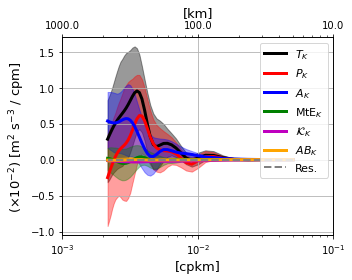

In [37]:
nz = 1

for reg in range(0,len(xs)-5):
    ds0 = xr.open_dataset(op.join(savedir,'isoDiags_u_region%02d_1967-01-01.zarr' % reg))
    ds1 = xr.open_dataset(op.join(savedir,'isoDiags_v_region%02d_1967-01-01.zarr' % reg))
    ds2 = xr.open_dataset(op.join(savedir,'isoDiags-ext_u_region%02d_1967-01-01.zarr' % reg))
    ds3 = xr.open_dataset(op.join(savedir,'isoDiags-ext_v_region%02d_1967-01-01.zarr' % reg))
    
    datas = ((ds0.iso_uT + ds1.iso_vT).isel(Z=nz).sum('angle')*np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Tres = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng)
    datas = ((ds0.iso_uAB + ds1.iso_vAB).isel(Z=nz).sum('angle')*np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    ABres = bootstrap(datas, np.mean, confidence_level=0.95,
                      random_state=rng)
    datas = ((ds0.iso_uP + ds1.iso_vP + ds2.iso_uE + ds3.iso_vE).isel(Z=nz).sum('angle')*np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Pres = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng)
    datas = ((ds2.iso_uD + ds3.iso_vD).isel(Z=nz).sum('angle')*np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Dres = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng)
        
    
    Tk = (ds0.iso_uT + ds1.iso_vT).mean(['nmemb']).sum('angle').compute()
    ABk = (ds0.iso_uAB + ds1.iso_vAB).mean(['nmemb']).sum('angle').compute()
    
    Pk = (ds0.iso_uP + ds1.iso_vP + ds2.iso_uE + ds3.iso_vE).mean(['nmemb']).sum('angle').compute()
    Dk = (ds2.iso_uD + ds3.iso_vD).mean(['nmemb']).sum('angle').compute()
    
    # ds4 = xr.open_dataset(op.join(savedir,'isoDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' % reg))
    # MtE = -(ds4.upupUx + ds4.vpupUy + ds4.wpupUz
    #         + ds4.upvpVx + ds4.vpvpVy + ds4.wpvpVz
    #        )
    ds4 = xr.open_dataset(op.join(savedir,'isoDiags-MtE_region%02d_1967-01-01.zarr' % reg))
    MtE = (ds4.iso_uA + ds4.iso_vA)
    
    datas = (MtE.isel(Z=nz).sum('angle').transpose('nmemb','scale')*np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    MtEres = bootstrap(datas, np.mean, confidence_level=0.95,
                       random_state=rng)
    datas = ((ds0.iso_uA + ds1.iso_vA - MtE).isel(Z=nz).sum('angle')*np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Ares = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng)
    
    Ak = (ds0.iso_uA + ds1.iso_vA
          - MtE
         ).mean(['nmemb']).sum('angle').compute()
    MtEk = MtE.mean(['nmemb']).sum('angle').compute()
    
    res = Tk/86400 - (Pk + (ds0.iso_uA + ds1.iso_vA).mean(['nmemb']).sum('angle').compute() 
                      + Dk + ABk
                     )
            
    fig, ax = plt.subplots(figsize=(5,4))
    fig.set_tight_layout(True)
    ax2 = ax.twiny()
    
    ax.fill_between((ds0.scale)**-1*1e3, Tres.confidence_interval.low/86400., Tres.confidence_interval.high/86400., 
                    alpha=.4, color='k')
    ax.fill_between((ds0.scale)**-1*1e3, Pres.confidence_interval.low, Pres.confidence_interval.high, 
                    alpha=.38, color='r')
    ax.fill_between((ds0.scale)**-1*1e3, Ares.confidence_interval.low, Ares.confidence_interval.high, 
                    alpha=.36, color='b')
    ax.fill_between((ds0.scale)**-1*1e3, MtEres.confidence_interval.low, MtEres.confidence_interval.high, 
                    alpha=.34, color='g')
    ax.fill_between((ds0.scale)**-1*1e3, Dres.confidence_interval.low, Dres.confidence_interval.high, 
                    alpha=.32, color='m')
    ax.fill_between((ds0.scale)**-1*1e3, ABres.confidence_interval.low, ABres.confidence_interval.high, 
                    alpha=.3, color='orange')
    
    ax.plot((ds0.scale)**-1*1e3, Tk.isel(Z=nz)*np.diff(ds0.angle)[0]*2*1e2/86400.,
            'k', lw=3, label=r"$T_K$")
    ax.plot((ds0.scale)**-1*1e3, Pk.isel(Z=nz)*np.diff(ds0.angle)[0]*2*1e2,
            'r', lw=3, label=r"$P_K$")
    ax.plot((ds0.scale)**-1*1e3, Ak.isel(Z=nz)*np.diff(ds0.angle)[0]*2*1e2,
            'b', lw=3, label=r"$A_K$")
    ax.plot((ds0.scale)**-1*1e3, MtEk.isel(Z=nz)*np.diff(ds0.angle)[0]*2*1e2,
            'g', lw=3, label=r"MtE$_K$")
    ax.plot((ds0.scale)**-1*1e3, (Dk).isel(Z=nz)*np.diff(ds0.angle)[0]*2*1e2,
            'm', lw=3, label=r"$\mathcal{K}_K$")
    ax.plot((ds0.scale)**-1*1e3, ABk.isel(Z=nz)*np.diff(ds0.angle)[0]*2*1e2,
            c='orange', lw=3, label=r"$AB_K$")
    ax.plot((ds0.scale)**-1*1e3, res.isel(Z=nz)*np.diff(ds0.angle)[0]*2*1e2, 
            c='grey', ls='--', lw=2, label=r"Res.")

    ax.set_xscale('log')
#             ax.set_yscale('log')
    ax2.set_xscale('log')
#             ax2.set_yscale('log')
    ax.set_xlim([1e-3,1e-1])
    ax2.set_xlim([1e-3,1e-1])
    ax2.set_xticks([1e-3,1e-2,1e-1])
    ax2.set_xticklabels([1e3,1e2,1e1])
    # Meta = np.abs(Pk.isel(Z=0)).max(skipna=True).values*1e3
    # ax.set_ylim([-Meta*.7, Meta*.7])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax2.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(r"($\times 10^{-2}$) [m$^2$ s$^{-3}$ / cpm]", fontsize=13)
    ax.grid(True)
    if reg % 5 == 0:
        ax.legend(loc='upper right', fontsize=11)
    plt.savefig(op.join(savedir,'Figs/SpecKEbudget_Region%02d_Z452.pdf' % reg))
    plt.show()

/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


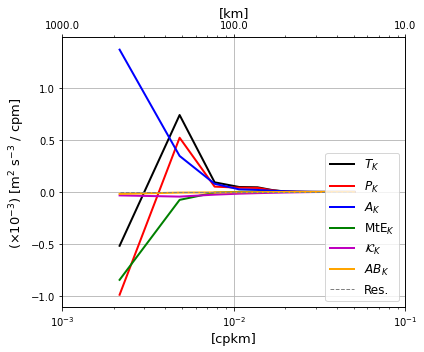

In [28]:
for reg in range(len(xs)-5):
    ds0 = xr.open_dataset(op.join(savedir,'crossFourierDiags_u_region%02d_1967-01-01.zarr' % reg))
    ds1 = xr.open_dataset(op.join(savedir,'crossFourierDiags_v_region%02d_1967-01-01.zarr' % reg))
    ds2 = xr.open_dataset(op.join(savedir,'crossFourierDiags-ext_u_region%02d_1967-01-01.zarr' % reg))
    ds3 = xr.open_dataset(op.join(savedir,'crossFourierDiags-ext_v_region%02d_1967-01-01.zarr' % reg))
    
    Tk = xrft.isotropize((ds0.cs_uT + ds1.cs_vT).mean(['nmemb']).real, ["freq_YC","freq_XC"], truncate=True).compute()
    ABk = xrft.isotropize((ds0.cs_uAB + ds1.cs_vAB).mean(['nmemb']).real, ["freq_YC","freq_XC"], truncate=True).compute()
    Pk = xrft.isotropize((ds0.cs_uP + ds1.cs_vP + ds2.cs_uE + ds3.cs_vE).mean(['nmemb']).real, ["freq_YC","freq_XC"], truncate=True).compute()
    
    Dk = xrft.isotropize((ds2.cs_uD + ds3.cs_vD).mean(['nmemb']).real, ["freq_YC","freq_XC"], truncate=True).compute()
    
    ds4 = xr.open_dataset(op.join(savedir,'crossFourierDiags-MtE_region%02d_1967-01-01.zarr' % reg))
    Ak = xrft.isotropize((ds0.cs_uA + ds1.cs_vA
                          - (ds4.MtEu + ds4.MtEv)
                         ).mean(['nmemb']).real, ["freq_YC","freq_XC"], truncate=True).compute()
    MtEk = xrft.isotropize((ds4.MtEu + ds4.MtEv).mean(['nmemb']).real, ["freq_YC","freq_XC"], truncate=True).compute()
    
    res = Tk/86400 - (Pk + xrft.isotropize((ds0.cs_uA + ds1.cs_vA).mean(['nmemb']).real, 
                                           ["freq_YC","freq_XC"], truncate=True).compute() 
                      + Dk + ABk)
            
            
    fig, ax = plt.subplots(figsize=(6,5))
    fig.set_tight_layout(True)
    ax2 = ax.twiny()
    ax.plot(Tk.freq_r*1e3, Tk.isel(Z=1)*1e3/86400.,
            'k', lw=2, label=r"$T_K$")
    ax.plot(Tk.freq_r*1e3, Pk.isel(Z=1)*1e3,
            'r', lw=2, label=r"$P_K$")
    ax.plot(Tk.freq_r*1e3, Ak.isel(Z=1)*1e3,
            'b', lw=2, label=r"$A_K$")
    ax.plot(Tk.freq_r*1e3, MtEk.isel(Z=1)*1e3,
            'g', lw=2, label=r"MtE$_K$")
    ax.plot(Tk.freq_r*1e3, (Dk).isel(Z=1)*1e3,
            'm', lw=2, label=r"$\mathcal{K}_K$")
    ax.plot(Tk.freq_r*1e3, ABk.isel(Z=1)*1e3,
            c='orange', lw=2, label=r"$AB_K$")
    ax.plot(Tk.freq_r*1e3, res.isel(Z=1)*1e3, 
            c='grey', ls='--', lw=1, label=r"Res.")

    ax.set_xscale('log')
#             ax.set_yscale('log')
    ax2.set_xscale('log')
#             ax2.set_yscale('log')
    ax.set_xlim([1e-3,1e-1])
    ax2.set_xlim([1e-3,1e-1])
    ax2.set_xticks([1e-3,1e-2,1e-1])
    ax2.set_xticklabels([1e3,1e2,1e1])
    # Meta = np.abs(Pk.isel(Z=0)).max(skipna=True).values*1e3
    # ax.set_ylim([-Meta*.7, Meta*.7])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax2.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(r"($\times 10^{-3}$) [m$^2$ s$^{-3}$ / cpm]", fontsize=13)
    ax.grid(True)
    if reg == 0:
        ax.legend(loc='lower right', fontsize=12)
    plt.savefig(op.join(savedir,'Figs/FourierSpecKEbudget_Region%02d_Z452.pdf' % reg))
    plt.show()

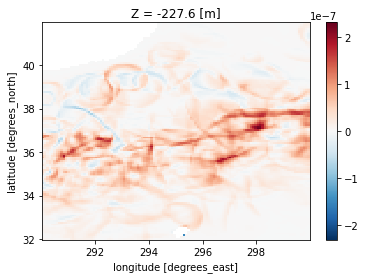

In [44]:
(grid.interp(upDv,'X',boundary='extend') 
 + grid.interp(vpDv,'Y',boundary='extend')
).isel(Z=14).plot()